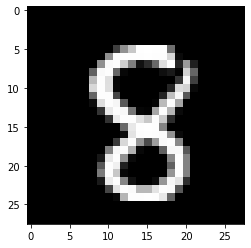

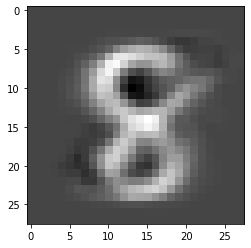

(784, 400) (784, 400)
Plotting training samples:: [9, 161, 188, 366, 396]


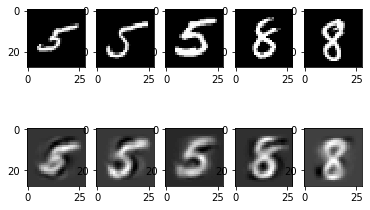

Shape of difference in means :: (10,)
Shape of Sw matrix ::(10, 10)
W.shape :: (10,) PCA_Train_data.shape(400, 10)
 Decision boundary in 1 dimension(say x), x= [[-2.08166817e-17]]
Sample Y plot with decision boundary in 1 dimension


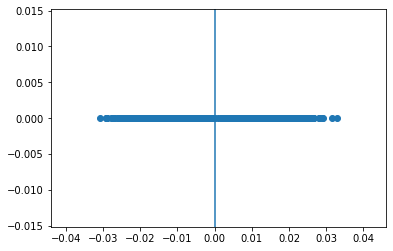

Training: 94.25
Testing: 93.0


In [3]:
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

datasets_dir = './Data/'


def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h


def mnist(noTrSamples=1000, noTsSamples=100, \
                        digit_range=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], \
                        noTrPerClass=100, noTsPerClass=10):
    assert noTrSamples==noTrPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    assert noTsSamples==noTsPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    data_dir = os.path.join(datasets_dir, 'mnist/')
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trData = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trLabels = loaded[8:].reshape((60000)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsData = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsLabels = loaded[8:].reshape((10000)).astype(float)

    trData = trData/255.
    tsData = tsData/255.

    tsX = np.zeros((noTsSamples, 28*28))
    trX = np.zeros((noTrSamples, 28*28))
    tsY = np.zeros(noTsSamples)
    trY = np.zeros(noTrSamples)

    count = 0
    for ll in digit_range:
        # Train data
        idl = np.where(trLabels == ll)
        idl = idl[0][: noTrPerClass]
        idx = list(range(count*noTrPerClass, (count+1)*noTrPerClass))
        trX[idx, :] = trData[idl, :]
        trY[idx] = trLabels[idl]
        # Test data
        idl = np.where(tsLabels == ll)
        idl = idl[0][: noTsPerClass]
        idx = list(range(count*noTsPerClass, (count+1)*noTsPerClass))
        tsX[idx, :] = tsData[idl, :]
        tsY[idx] = tsLabels[idl]
        count += 1
    
    np.random.seed(1)
    test_idx = np.random.permutation(tsX.shape[0])
    tsX = tsX[test_idx,:]
    tsY = tsY[test_idx]

    trX = trX.T
    tsX = tsX.T
    trY = trY.reshape(1, -1)
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY


def compute_pca(data, is_inverse_transform=False, n_components=10):
    pca = PCA(n_components=n_components)
    if not is_inverse_transform:
        return pca.fit_transform(data)
    r_train = pca.fit_transform(data)
    return pca.inverse_transform(r_train)

def compute_pca_test(data, test_data, n_components=10):
    pca = PCA(n_components=n_components)
    r_train = pca.fit_transform(data)
    return pca.transform(test_data)


def compute_2a(trX, trY):
    trXT = trX.T
    r_train = compute_pca(trXT, n_components=10)
    recons_train = compute_pca(trXT, is_inverse_transform=True)
    plt.imshow(trXT[399,:].reshape(28, -1), cmap=plt.cm.gray)
    plt.show()
    plt.imshow(recons_train[399,:].reshape(28, -1), cmap=plt.cm.gray)
    plt.show()
    return r_train

def compute_2b(original_img_data, pca_transformed_img_data):
    print(original_img_data.shape, pca_transformed_img_data.shape)
    
    random_indices = sorted(np.random.randint(0, 400, size=(1,5))[0])
    print("Plotting training samples::", random_indices)
    figure, axes = plt.subplots(2,5)
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            if i == 0:
                axes[i, j].imshow(original_img_data[:,random_indices[j]].reshape(28,-1), cmap=plt.cm.gray)
            elif i == 1:
                axes[i, j].imshow(pca_transformed_img_data[:,random_indices[j]].reshape(28,-1), cmap=plt.cm.gray)
    
    plt.show()

def compute_2c(r_train):
    mu1 = np.mean(r_train[0:200,:], axis = 0)
    mu2 = np.mean(r_train[200:400,:], axis = 0)
    diff_in_means = mu2 - mu1
    print("Shape of difference in means :: " + str(diff_in_means.shape))

    s1 = ((r_train[0:200,:] - mu1.reshape(1,-1)).T).dot((r_train[0:200,:] - mu1.reshape(1,-1)))
    s2 = ((r_train[200:400,:] - mu2.reshape(1,-1)).T).dot((r_train[200:400,:] - mu2.reshape(1,-1)))
    sw = s1+s2
    print("Shape of Sw matrix ::" + str(sw.shape))

    sw_inverse = np.linalg.inv(sw)

    # w is directly proportional to sw_inverse * (mu2 - mu1)
    w_matrix = sw_inverse.dot(diff_in_means)

    #Verifying shapes before projection
    print("W.shape :: " + str(w_matrix.shape), "PCA_Train_data.shape" + str(r_train.shape))

    ## Y = X * W
    y = r_train.dot(w_matrix)

    #Projection of class means to compute decision boundary
    class_1 = w_matrix.reshape(1,-1).dot(mu1.reshape(1,-1).T)
    class_2 = w_matrix.reshape(1,-1).dot(mu2.reshape(1,-1).T)

    decision_boundary = (class_1 + class_2) / 2
    print(" Decision boundary in 1 dimension(say x), x=", decision_boundary)
    
    # Sample Y plot in 1 dimensions
    print("Sample Y plot with decision boundary in 1 dimension")
    plt.scatter(y, np.zeros((y.shape)))
    plt.axvline(decision_boundary)
    plt.show()
    return w_matrix, decision_boundary
    
    
def compute_accuracy_2c(r_train, w_matrix, decision_boundary, train_mnist_count, test_mnist_count, pca_test_data):
    misclassified_5 = 0
    for image_vector in r_train[0:200]:
        value = w_matrix.reshape(1,-1).dot(image_vector.reshape(1,-1).T)
        if value > decision_boundary:
            misclassified_5 = misclassified_5 + 1
    misclassified_8 = 0
    for image_vector in r_train[200:400]:
        value = w_matrix.reshape(1,-1).dot(image_vector.reshape(1,-1).T)
        if value < decision_boundary:
            misclassified_8 = misclassified_8 + 1
    training_misclassification = misclassified_5 + misclassified_8
    train_accuracy = ((train_mnist_count -  training_misclassification) / train_mnist_count) * 100
    print("Training:", train_accuracy)

    # Computing test accuracy
    testing_misclassification = 0
    for i, image_vector in enumerate(pca_test_data):
        projected_value = w_matrix.reshape(1,-1).dot(image_vector.reshape(1,-1).T)
        class_value = -1
        if projected_value > decision_boundary:
            class_value = 8.0
        elif projected_value < decision_boundary:
            class_value = 5.0
        if class_value != tsY[0][i]:
            testing_misclassification = testing_misclassification + 1
    test_accuracy = test_mnist_count - testing_misclassification
    print("Testing:", float(test_accuracy))

def main():
    trX, trY, tsX, tsY = mnist(noTrSamples=400,
                           noTsSamples=100, digit_range=[5, 8],
                           noTrPerClass=200, noTsPerClass=50)

    #2A
    r_train = compute_2a(trX=trX, trY=trY)

    #2B
    compute_2b(trX, compute_pca(trX, is_inverse_transform=True))

    #2C
    w_matrix, decision_boundary = compute_2c(r_train=r_train)
    pca_test_data = compute_pca_test(trX.T, tsX.T, n_components=10)
    compute_accuracy_2c(r_train, w_matrix, decision_boundary, r_train.shape[0], tsX.T.shape[0], pca_test_data)

if __name__ == '__main__':
    main()